<h3>  Imports </h3>

In [1]:
import numpy as np
import time
import matplotlib.cm as cm 
import matplotlib.pyplot as plt

# Fetching datasets 

In [2]:
datasets_path = "/Users/31_grudnia/Desktop/Python/Playground/Masters_Degree_Project/backend/MNIST_app/MNIST_utils_files/signs_with_labels/"

# Train datasets
X_train: np.ndarray = np.load(datasets_path + "X_train.npy")
Y_train: np.ndarray = np.load(datasets_path + "Y_train.npy")

In [3]:
# Test datasets
X_test: np.ndarray = np.load(datasets_path + "X_test.npy")
Y_test: np.ndarray = np.load(datasets_path + "Y_test.npy")

In [4]:
# Validation datasets
X_val: np.ndarray = np.load(datasets_path + "X_val.npy")
Y_val: np.ndarray = np.load(datasets_path + "Y_val.npy")

In [5]:
X_train, X_test, X_val = X_train / 255., X_test / 255., X_val / 255.

# One Hot Encoder

In [6]:
def one_hot_encoder(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a.reshape(-1)]) 

# Normalization 

In [7]:
def normalize(X):
    X_normalize = (X - np.min(X)) / (np.max(X) - np.min(X))
    return X_normalize 

In [8]:
X_train = normalize(np.array([np.ravel(x) for x in X_train]))
Y_train_ohe = np.array([one_hot_encoder(np.array(y, dtype=int), 89) for y in Y_train], dtype=int)
print(f"Shape X: {X_train.shape}, Shape Y: {Y_train_ohe.shape}")

Shape X: (446524, 1024), Shape Y: (446524, 89)


# Optimizers

** unused **

In [9]:
class Optimizers:
    
    @staticmethod
    def SGD(w, dw, alpha=0.01, beta=0.09):
        w = w - alpha * dw
        return w

# Loss Functions

In [10]:
class LossFunctions:
    
    @staticmethod
    def Categorical_Crossentropy(y_pred, y_true):
        return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))


# Activation Functions

In [11]:
class Relu():
    def __init__(self):
        pass
    
    def forward(self, input):
        # Apply elementwise relu to [batch, input_units] matrix
        relu_forward = np.maximum(0, input)
        return relu_forward
    
    def backward(self, input, grad_output):
        # Compute gradient of loss w.r.t. ReLU input
        relu_grad = input > 0
        return grad_output * relu_grad

In [12]:
class Softmax:
    
    @staticmethod
    def softmax_crossentropy_with_logits(logits, reference_answers):
    # Compute crossentropy from logits[batch,n_classes] and ids of correct answers                 
        logits_for_answers = logits[np.arange(len(logits)), reference_answers]    
        xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits), axis=-1))    
        return xentropy

    @staticmethod
    def grad_softmax_crossentropy_with_logits(logits, reference_answers):
        # Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers
        ones_for_answers = np.zeros_like(logits)
        ones_for_answers[np.arange(len(logits)), reference_answers] = 1    
        softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)    
        return (- ones_for_answers + softmax) / logits.shape[0]

# Layers
- Dense
    - Init of parameters (bias and weights)
    - Forward Propagation
    - Backward Propagation

In [13]:
class Layer:
    def __init__(self):        
        pass
    
    def forward(self, input):
        # Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        # A dummy layer just returns whatever it gets as input.
        return input
    
    def backward(self, input, grad_output):
        # Performs a backpropagation step through the layer, with respect to the given input.
        # To compute loss gradients w.r.t input, we need to apply chain rule (backprop):
        # d loss / d x  = (d loss / d layer) * (d layer / d x)
        # Luckily, we already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.
        # If our layer has parameters (e.g. dense layer), we also need to update them here using d loss / d layer
        # The gradient of a dummy layer is precisely grad_output, but we'll write it more explicitly 
        num_units = input.shape[1]
        d_layer_d_input = np.eye(num_units)
        return np.dot(grad_output, d_layer_d_input) # chain rule

In [14]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate = 0.1):
        # A dense layer is a layer which performs a learned affine transformation: f(x) = <W*x> + b
        self.learning_rate = learning_rate
        self.weights = np.random.normal(loc=0.0, scale = np.sqrt(2 / (input_units + output_units)), size = (input_units, output_units))
        self.biases = np.zeros(output_units)
    
    def forward(self, input):
        # Perform an affine transformation: f(x) = <W*x> + b        
        # input shape: [batch, input_units]
        # output shape: [batch, output units]        
        return np.dot(input, self.weights) + self.biases
    
    def backward(self, input, grad_output):
        # compute d f / d x = d f / d dense * d dense / d x where d dense/ d x = weights transposed
        grad_input = np.dot(grad_output, self.weights.T)
        
        # compute gradient w.r.t. weights and biases
        grad_weights = np.dot(input.T, grad_output)
        grad_biases = grad_output.mean(axis=0) * input.shape[0]
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        
        # Here we perform a stochastic gradient descent step. 
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input


# Neural Network

In [15]:
class NeuralNetwork(object):
    def __init__(self):
        self.layers = []
        
    def add_layer(self, layer):
        self.layers.append(layer)
    
    def forward(self, X):
        # Compute activations of all network layers by applying them sequentially.
        # Return a list of activations for each layer. 
        activations = []
        input = X
        
        # Looping through each layer
        for l in self.layers:
            activations.append(l.forward(input))
            # Updating input to last layer output
            input = activations[-1]
    
        assert len(activations) == len(self.layers)
        return activations
    
    
    def train_batch(self, X, y):
        # Train our network on a given batch of X and y.
        # We first need to run forward to get all layer activations.
        # Then we can run layer.backward going from last to first layer.
        # After we have called backward for all layers, all Dense layers have already made one gradient step.
        
        layer_activations = self.forward(X)
        layer_inputs = [X] + layer_activations  # layer_input[i] is an input for layer[i]
        logits = layer_activations[-1]
        
        # Compute the loss and the initial gradient    
        y_argmax =  y.argmax(axis=1)        
        loss = Softmax.softmax_crossentropy_with_logits(logits, y_argmax)
        loss_grad = Softmax.grad_softmax_crossentropy_with_logits(logits, y_argmax)
    
        # Propagate gradients through the network
        # Reverse propogation as this is backprop
        for layer_index in range(len(self.layers))[::-1]:
            layer = self.layers[layer_index]        
            loss_grad = layer.backward(layer_inputs[layer_index], loss_grad) # grad w.r.t. input, also weight updates
        
        return np.mean(loss)
    
    def train(self, X_train, y_train, n_epochs = 25, batch_size = 100):
        train_log = []
        loss_log = []
        
        for epoch in range(n_epochs):
            epoch_losses = []
            for i in range(0, X_train.shape[0], batch_size):
                x_batch = np.array([x.flatten() for x in X_train[i:i + batch_size]])
                y_batch = np.array([y for y in y_train[i:i + batch_size]])
                batch_loss = self.train_batch(x_batch, y_batch)
                epoch_losses.append(batch_loss)
            
            avg_loss = np.mean(epoch_losses)
            accuracy = np.mean(self.predict(X_train) == y_train.argmax(axis=-1))
            train_log.append(accuracy)
            loss_log.append(avg_loss)
            print(f"Epoch: {epoch + 1}, Train accuracy: {accuracy}, Loss: {avg_loss}")
            
        return train_log, loss_log
    
    def predict(self, X):
        # Compute network predictions. Returning indices of largest Logit probability
        logits = self.forward(X)[-1]
        return logits.argmax(axis=-1)


In [16]:
input_size = X_train.shape[1]
output_size = Y_train_ohe.shape[1]

In [17]:
MNIST_NeuralNetwork = NeuralNetwork()
MNIST_NeuralNetwork.add_layer(Dense(input_size, 256, learning_rate = 0.05))
MNIST_NeuralNetwork.add_layer(Relu())
MNIST_NeuralNetwork.add_layer(Dense(256, 128, learning_rate = 0.05))
MNIST_NeuralNetwork.add_layer(Relu())
MNIST_NeuralNetwork.add_layer(Dense(128, output_size))

Epoch: 1, Train accuracy: 0.5199563741254669, Loss: 1.4950767642324436
Epoch: 2, Train accuracy: 0.5372006879809372, Loss: 0.9187739435789779
Epoch: 3, Train accuracy: 0.6636798917863318, Loss: 0.8079074197253947
Epoch: 4, Train accuracy: 0.7060113230195914, Loss: 0.7493335981440518
Epoch: 5, Train accuracy: 0.713280809094248, Loss: 0.7109172835259172
Epoch: 6, Train accuracy: 0.7289664161388861, Loss: 0.6828040777570626
Epoch: 7, Train accuracy: 0.7498544311168045, Loss: 0.6609574615025564
Epoch: 8, Train accuracy: 0.7495700119142532, Loss: 0.6434288789155864
Epoch: 9, Train accuracy: 0.7585101808637386, Loss: 0.628071656715444
Epoch: 10, Train accuracy: 0.7648144332667449, Loss: 0.6152097011523877


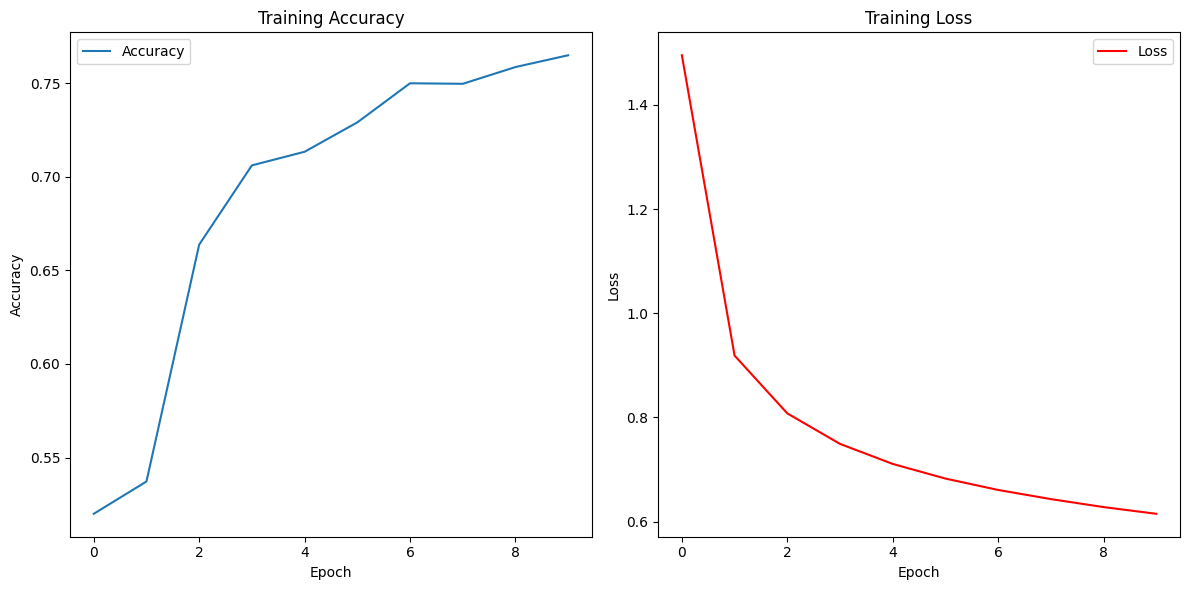

In [18]:
train_log, loss_log = MNIST_NeuralNetwork.train(X_train, Y_train_ohe, n_epochs = 10, batch_size = 100)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_log, label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss_log, label='Loss', color='red')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
MNIST_NeuralNetwork.

SyntaxError: invalid syntax (1981973062.py, line 1)

# Tests

In [ ]:
print(X_train_flattened.shape)

(446524, 1024)


In [ ]:
print(f"Xtrain shape: {X_train.shape}")
print(f"Ytrain shape: {Y_train.shape}")
print(f"Ytrainohe shape: {len(Y_train_ohe)}")
print(Y_train_ohe[1])

Xtrain shape: (446524, 32, 32)
Ytrain shape: (446524,)
Ytrainohe shape: 446524
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
print(X_train.shape, Y_train.shape)

(446524, 32, 32) (446524,)


(446524,)
(446524, 32, 32)


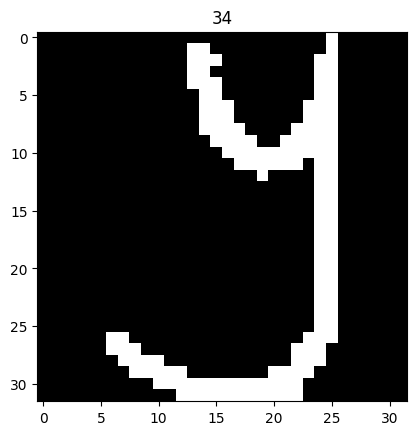

In [ ]:
print(Y_train.shape)
print(X_train.shape)
index = 7
plt.title((Y_train[index]))
plt.imshow(X_train[index].reshape(32, 32), cmap=cm.binary)

In [ ]:
import tensorflow as tf

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(32, 32)),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(89, activation='softmax')
])

model.compile(optimizer='SGD',
  loss='categorical_crossentropy',
  metrics=['accuracy'])

model.fit(X_train, Y_train_ohe, epochs=15, batch_size=100)
model.evaluate(X_test, Y_test_ohe)

In [ ]:
predictions = model.predict(X_val)
predicted_class_indices = np.argmax(predictions, axis=1)


1745/1745 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [ ]:
all_chars = 500
true_labels = 0
for i in range(all_chars):
    print(f"Index: {i}; Prediction: {predicted_class_indices[i]}; True Label: {Y_val[i]}")
    if predicted_class_indices[i] == Y_val[i]:
        true_labels += 1
print(f"Accuracy on valid set: {(true_labels/all_chars) * 100}%")



Index: 0; Prediction: 79; True Label: 79
Index: 1; Prediction: 84; True Label: 84
Index: 2; Prediction: 38; True Label: 12
Index: 3; Prediction: 11; True Label: 11
Index: 4; Prediction: 36; True Label: 36
Index: 5; Prediction: 61; True Label: 2
Index: 6; Prediction: 26; True Label: 26
Index: 7; Prediction: 44; True Label: 44
Index: 8; Prediction: 11; True Label: 11
Index: 9; Prediction: 49; True Label: 49
Index: 10; Prediction: 68; True Label: 68
Index: 11; Prediction: 54; True Label: 28
Index: 12; Prediction: 43; True Label: 43
Index: 13; Prediction: 15; True Label: 15
Index: 14; Prediction: 14; True Label: 14
Index: 15; Prediction: 44; True Label: 1
Index: 16; Prediction: 68; True Label: 68
Index: 17; Prediction: 3; True Label: 9
Index: 18; Prediction: 59; True Label: 59
Index: 19; Prediction: 86; True Label: 86
Index: 20; Prediction: 13; True Label: 13
Index: 21; Prediction: 48; True Label: 48
Index: 22; Prediction: 78; True Label: 78
Index: 23; Prediction: 76; True Label: 76
Index: